# Part1: Data Pre-Processing, TF-IDF vector

##### PCF dataset only

In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [10]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/susanlin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/susanlin/nltk_data...


True

In [2]:
# set file path
dataset_path = os.path.dirname(os.path.abspath(__name__))
output_path = os.path.join(dataset_path, "output")

In [3]:
# Define functions
def remove_links(df, column):
    df = df[~df[column].str.contains("http")]
    return df.reset_index(drop=True)


def delete_short_row(min_word, df, column):
    split_word = df[column].str.split()
    words_count = split_word.apply(lambda x: len(x))
    return df[words_count > min_word]


def text_lemmatize(text):
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text


def split_four_type(df, column):
    split_type = df[column].str.split('', expand=True)
    df['E/I'] = split_type[1]
    df['S/N'] = split_type[2]
    df['T/F'] = split_type[3]
    df['J/P'] = split_type[4]

In [4]:
# import data
pcf_data = pd.read_csv(os.path.join(dataset_path, 'mbti_1.csv'))

In [5]:
# split posts
split_posts = pcf_data['posts'].str.extractall(r'([^|||]+)').unstack()
split_posts.columns = [f'Post {i+1}' for i in range(split_posts.shape[1])]
new_pcf_data = pd.concat([pcf_data, split_posts], axis=1)

# change value_name to 'new_posts'
new_pcf_data = new_pcf_data.melt(id_vars=['type'], value_vars=[f'Post {i+1}' for i in range(split_posts.shape[1])], value_name='new_posts').drop('variable', axis=1).dropna()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/strings/accessor.py:3483: FutureWarning: Possible set union at position 4
  regex = re.compile(pat, flags=flags)


In [6]:
# remove posts with link
new_pcf_data = remove_links(new_pcf_data, "new_posts")


In [7]:
# lemmatization
new_pcf_data['new_posts'] = new_pcf_data['new_posts'].apply(text_lemmatize)


In [8]:
# split 4 types
split_four_type(new_pcf_data, 'type')

In [9]:
# input platform name
new_pcf_data = new_pcf_data.assign(media='PCF')

In [10]:
# delete posts that are too short
new_pcf_data = delete_short_row(3, new_pcf_data, "new_posts")

In [11]:
# randomly pick 50000 data
random_sample = new_pcf_data.sample(n=50000, random_state=42)

# get TF-IDF vector
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
tfidf_vectors = tfidf_vectorizer.fit_transform(random_sample['new_posts']).toarray()

# add TF-IDF vector into random_sample DataFrame 
random_sample['tfidf_vec'] = list(tfidf_vectors)


print(random_sample)

        type                                          new_posts E/I S/N T/F  \
294068  ENTP  As for me , and for the most of the time , the...   E   N   T   
41301   INFJ  I love hug , but I wo n't hug people for that ...   I   N   F   
107261  ISTJ  I 'm ISTJ ... my mom be ISTJ ... her mom be IS...   I   S   T   
39666   INTJ  So ... * clear throat * ... be the guy that wo...   I   N   T   
251990  INFP  Welcome to PerC , Anadalaya and hope you enjoy...   I   N   F   
...      ...                                                ...  ..  ..  ..   
131947  ENFP  Hi everyone . The world right now have become ...   E   N   F   
226637  INTJ  I 'm quite narcissistic . In fact , that 's wh...   I   N   T   
360439  INTJ  ISTJ TMLT think Mathematics be much greater th...   I   N   T   
109732  INFJ  Had one experience with an ENFP . We seem to j...   I   N   F   
120274  INTJ  ... I 'm not sure on that ... can you get away...   I   N   T   

       J/P media                                   

In [14]:
# save as csv file
output_file = os.path.join(output_path, 'output_TFIDF.csv')
random_sample[['new_posts', 'tfidf_vec', 'media', 'type','E/I','S/N','T/F','J/P']].to_csv(output_file, index=False)


# Part2: MBTI classication - Model Training, Testing and Comparison
#### 90/10 split
(split traing, testing set and than turn into TF-IDF vector)

In [15]:
import os
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
# split training and testing dataset
train_data, test_data = train_test_split(random_sample, test_size=0.1, random_state=42)


In [17]:
# define vectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')

# turn training set into TF-IDF vector
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['new_posts'])
# turn testing set into TF-IDF vector
X_test_tfidf = tfidf_vectorizer.transform(test_data['new_posts'])


In [18]:
y_train = train_data['type']
y_test = test_data['type']

In [19]:
# define classifier
knn_classifier = KNeighborsClassifier()
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier()

In [20]:
# train model
knn_classifier.fit(X_train_tfidf, y_train)
nb_classifier.fit(X_train_tfidf, y_train)
rf_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [21]:
# prediction
knn_pred = knn_classifier.predict(X_test_tfidf)
nb_pred = nb_classifier.predict(X_test_tfidf)
rf_pred = rf_classifier.predict(X_test_tfidf)

In [22]:
# calculate accuracy and F1 score
knn_accuracy = accuracy_score(y_test, knn_pred)
nb_accuracy = accuracy_score(y_test, nb_pred)
rf_accuracy = accuracy_score(y_test, rf_pred)


knn_f1 = f1_score(y_test, knn_pred, average='weighted')
nb_f1 = f1_score(y_test, nb_pred, average='weighted')
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

# print("KNN Accuracy:", knn_accuracy)
# print("KNN F1 Score:", knn_f1)
# print("Multinomial Naive Bayes Accuracy:", nb_accuracy)
# print("Multinomial Naive Bayes F1 Score:", nb_f1)
# print("Random Forest Classifier Accuracy:", rf_accuracy)
# print("Random Forest Classifier F1 Score:", rf_f1)

KNN Accuracy: 0.0904
KNN F1 Score: 0.05124575549133223
Multinomial Naive Bayes Accuracy: 0.2344
Multinomial Naive Bayes F1 Score: 0.13808419748265302
Random Forest Classifier Accuracy: 0.253
Random Forest Classifier F1 Score: 0.21918650993164907


In [26]:
# Print classification report
print("KNN MBTI Classification Report:")
print(classification_report(test_data['type'], knn_pred))

print("Multinomial Naive Bayes MBTI Classification Report:")
print(classification_report(test_data['type'], nb_pred))

print("Random Forest MBTI Classification Report:")
print(classification_report(test_data['type'], rf_pred))

KNN MBTI Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        95
        ENFP       0.08      0.87      0.14       384
        ENTJ       0.07      0.01      0.01       141
        ENTP       0.08      0.01      0.01       377
        ESFJ       0.00      0.00      0.00        19
        ESFP       0.00      0.00      0.00        29
        ESTJ       0.00      0.00      0.00        25
        ESTP       0.00      0.00      0.00        47
        INFJ       0.15      0.03      0.05       885
        INFP       0.29      0.05      0.08      1055
        INTJ       0.19      0.04      0.07       618
        INTP       0.31      0.01      0.03       764
        ISFJ       0.00      0.00      0.00       107
        ISFP       0.00      0.00      0.00       148
        ISTJ       0.12      0.02      0.03       126
        ISTP       0.00      0.00      0.00       180

    accuracy                           0.09     

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

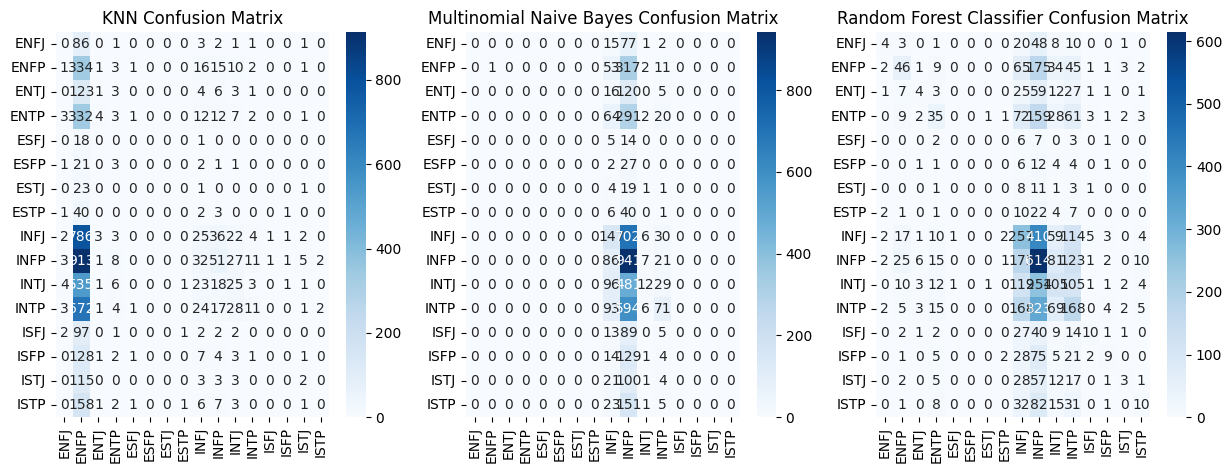

In [23]:
# Confusion matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(y_test, knn_pred), annot=True, fmt='d', cmap='Blues', xticklabels=knn_classifier.classes_, yticklabels=knn_classifier.classes_)
plt.title('KNN Confusion Matrix')

plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix(y_test, nb_pred), annot=True, fmt='d', cmap='Blues', xticklabels=nb_classifier.classes_, yticklabels=nb_classifier.classes_)
plt.title('Multinomial Naive Bayes Confusion Matrix')

plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.title('Random Forest Classifier Confusion Matrix')

plt.show()

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_41463/1250103401.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


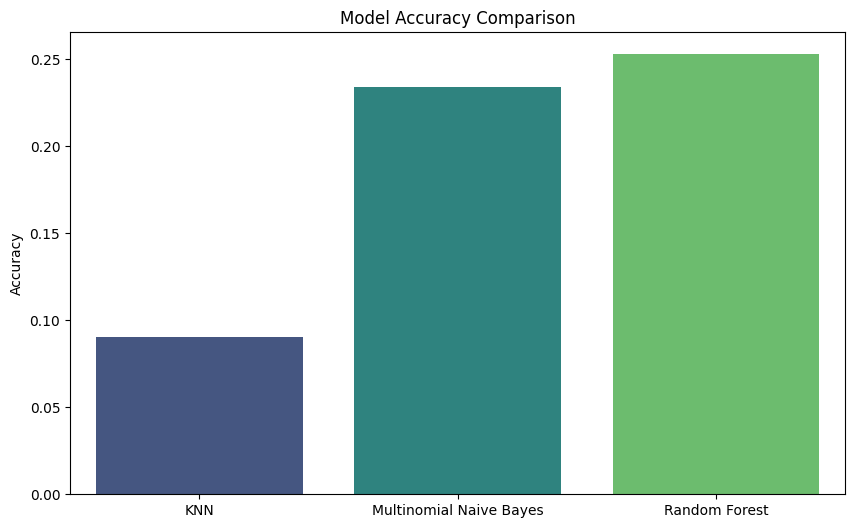

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_41463/1250103401.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=f1_scores, palette='viridis')


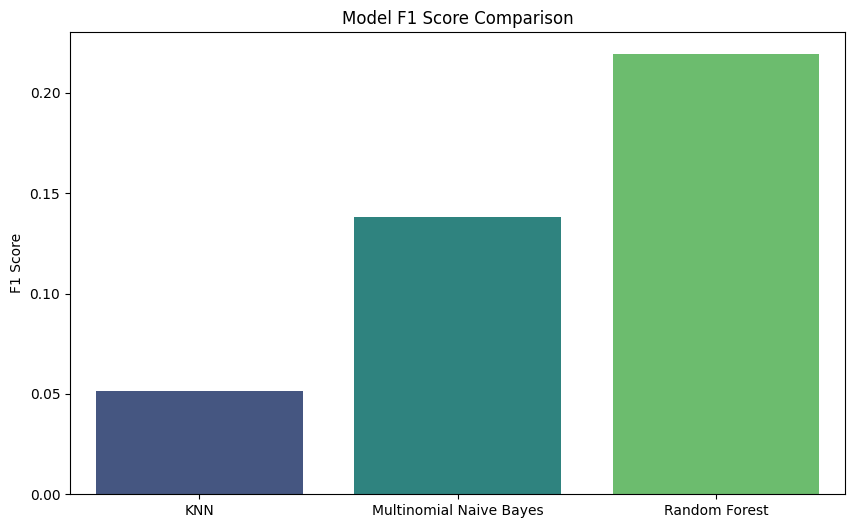

In [24]:
# Evaluate models
models = ['KNN', 'Multinomial Naive Bayes', 'Random Forest']
accuracies = [knn_accuracy, nb_accuracy, rf_accuracy]
f1_scores = [knn_f1, nb_f1, rf_f1]

# Visualize performance
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
ax.set_title('Model Accuracy Comparison')
ax.set_ylabel('Accuracy')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=models, y=f1_scores, palette='viridis')
ax.set_title('Model F1 Score Comparison')
ax.set_ylabel('F1 Score')
plt.show()

# Part 3: Binary Classification

In [27]:
# Define classifiers
classifiers = {
    'KNN': KNeighborsClassifier(),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier()
}


Classification for E/I:

KNN Classification Report:
              precision    recall  f1-score   support

           E       0.39      0.01      0.03      1117
           I       0.78      0.99      0.87      3883

    accuracy                           0.78      5000
   macro avg       0.59      0.50      0.45      5000
weighted avg       0.69      0.78      0.68      5000



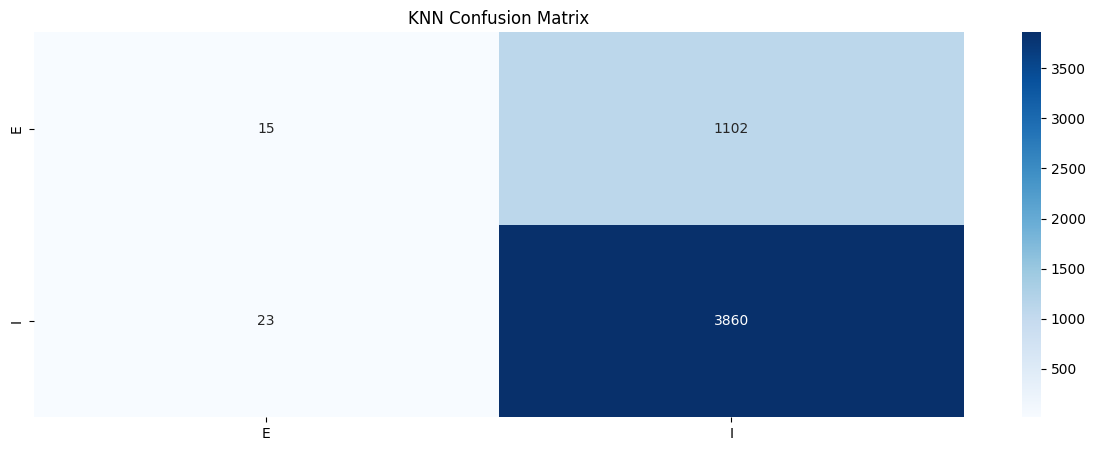

Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

           E       0.14      0.00      0.00      1117
           I       0.78      1.00      0.87      3883

    accuracy                           0.78      5000
   macro avg       0.46      0.50      0.44      5000
weighted avg       0.63      0.78      0.68      5000



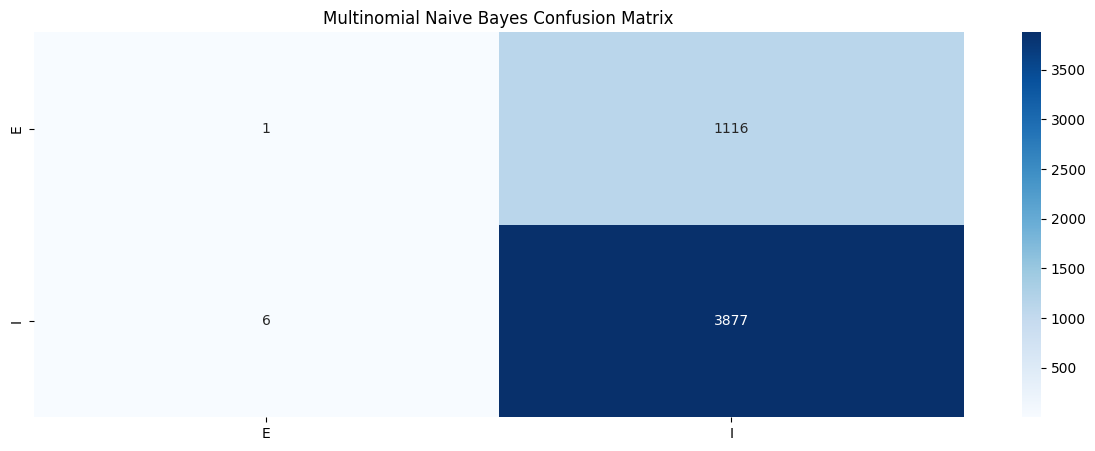

Random Forest Classification Report:
              precision    recall  f1-score   support

           E       0.43      0.08      0.14      1117
           I       0.79      0.97      0.87      3883

    accuracy                           0.77      5000
   macro avg       0.61      0.53      0.50      5000
weighted avg       0.71      0.77      0.71      5000



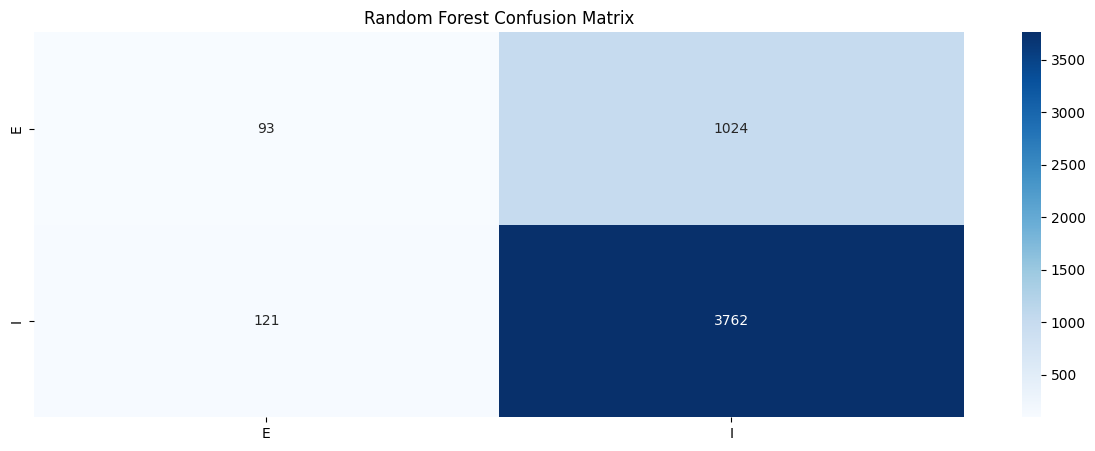


Classification for S/N:

KNN Classification Report:
              precision    recall  f1-score   support

           N       0.86      1.00      0.93      4319
           S       0.27      0.01      0.01       681

    accuracy                           0.86      5000
   macro avg       0.57      0.50      0.47      5000
weighted avg       0.78      0.86      0.80      5000



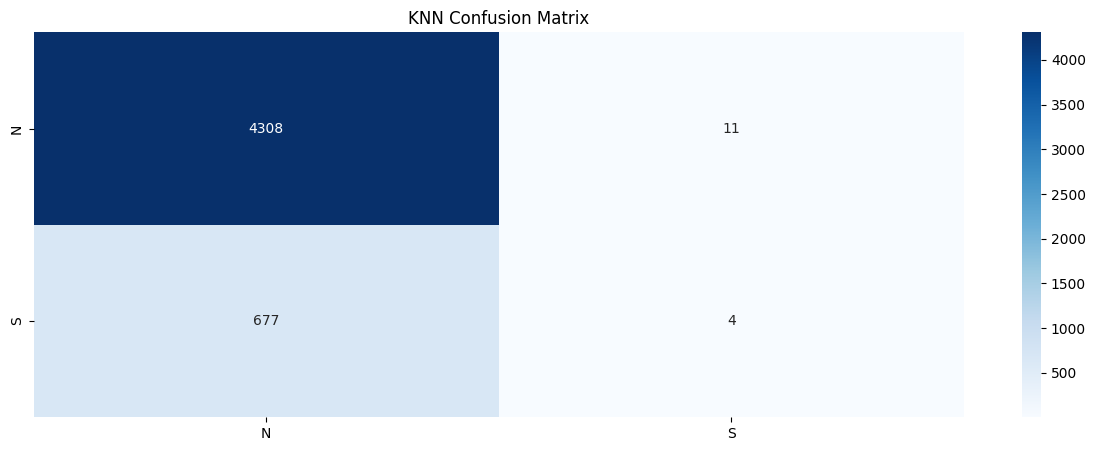

Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

           N       0.86      1.00      0.93      4319
           S       0.00      0.00      0.00       681

    accuracy                           0.86      5000
   macro avg       0.43      0.50      0.46      5000
weighted avg       0.75      0.86      0.80      5000



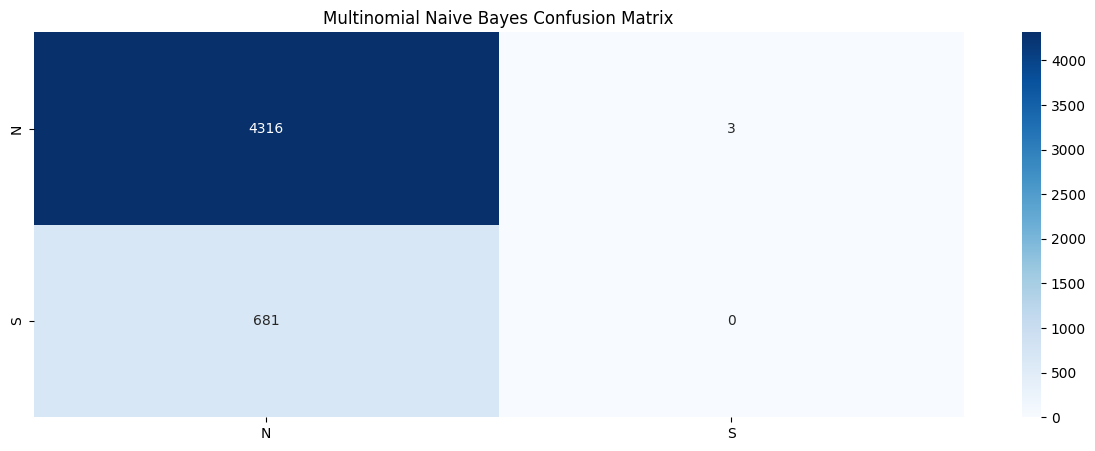

Random Forest Classification Report:
              precision    recall  f1-score   support

           N       0.87      0.99      0.92      4319
           S       0.38      0.05      0.08       681

    accuracy                           0.86      5000
   macro avg       0.62      0.52      0.50      5000
weighted avg       0.80      0.86      0.81      5000



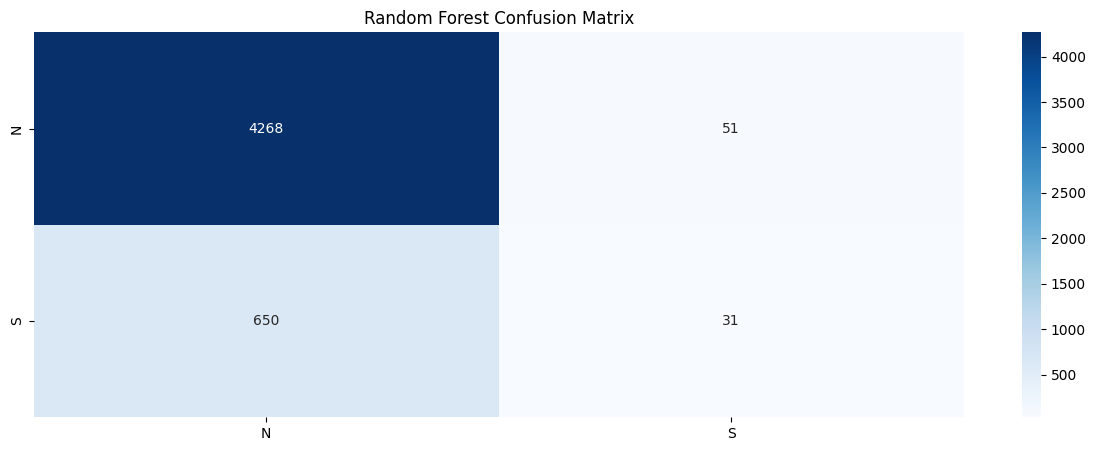


Classification for T/F:

KNN Classification Report:
              precision    recall  f1-score   support

           F       0.55      0.94      0.69      2722
           T       0.48      0.07      0.12      2278

    accuracy                           0.54      5000
   macro avg       0.52      0.50      0.40      5000
weighted avg       0.52      0.54      0.43      5000



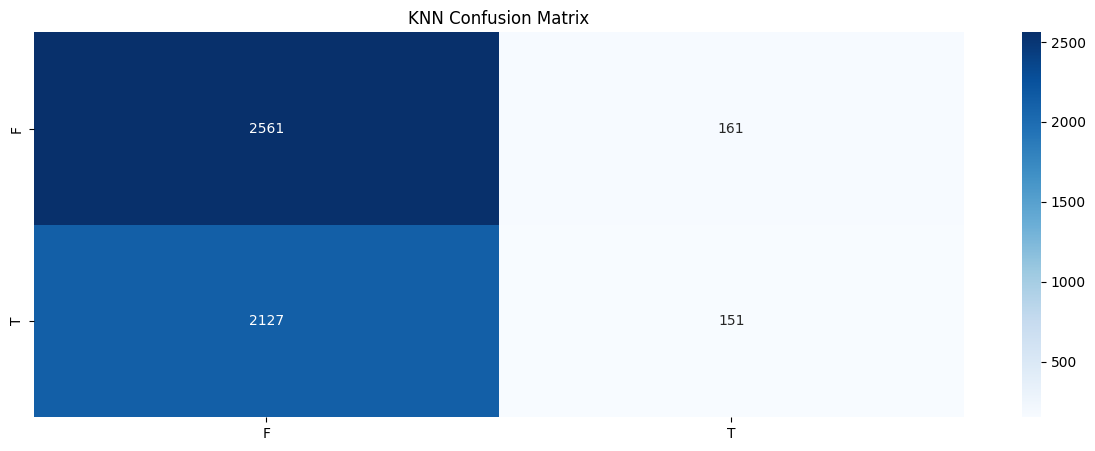

Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

           F       0.60      0.84      0.70      2722
           T       0.62      0.32      0.42      2278

    accuracy                           0.60      5000
   macro avg       0.61      0.58      0.56      5000
weighted avg       0.61      0.60      0.57      5000



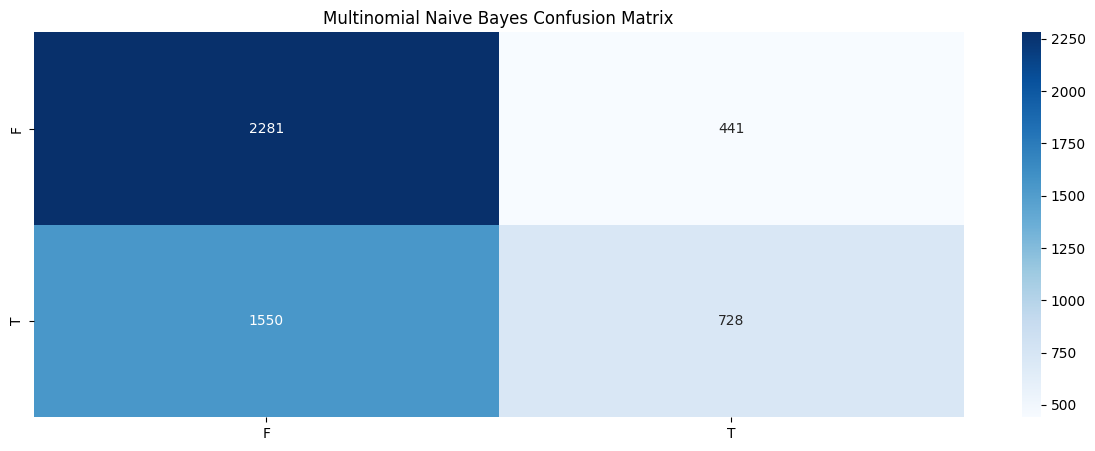

Random Forest Classification Report:
              precision    recall  f1-score   support

           F       0.60      0.75      0.67      2722
           T       0.57      0.40      0.47      2278

    accuracy                           0.59      5000
   macro avg       0.59      0.58      0.57      5000
weighted avg       0.59      0.59      0.58      5000



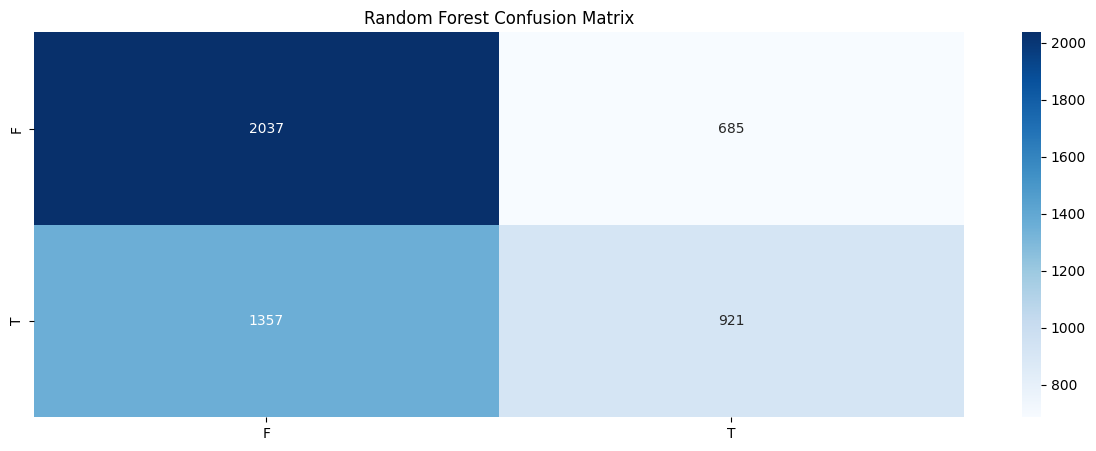


Classification for J/P:

KNN Classification Report:
              precision    recall  f1-score   support

           J       0.40      0.90      0.56      2016
           P       0.61      0.10      0.18      2984

    accuracy                           0.43      5000
   macro avg       0.51      0.50      0.37      5000
weighted avg       0.53      0.43      0.33      5000



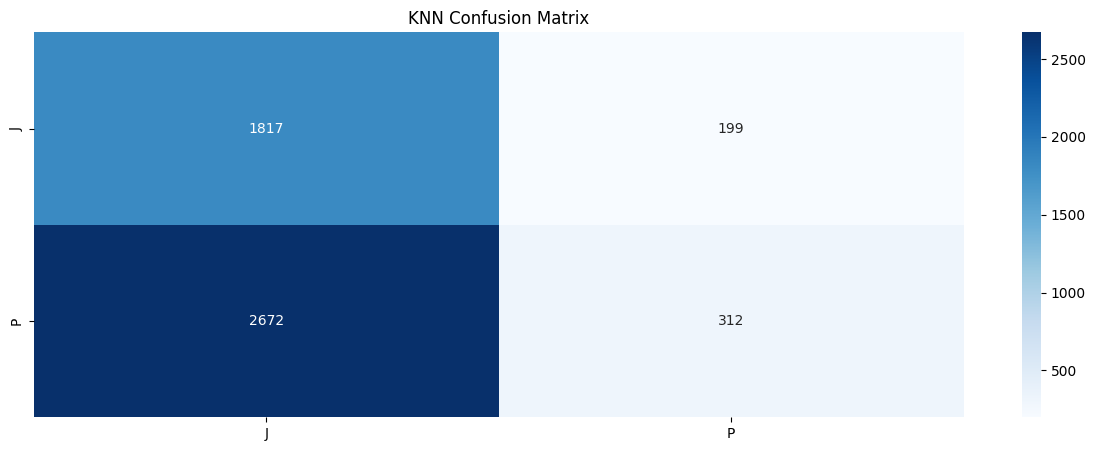

Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

           J       0.53      0.06      0.11      2016
           P       0.60      0.96      0.74      2984

    accuracy                           0.60      5000
   macro avg       0.56      0.51      0.43      5000
weighted avg       0.57      0.60      0.49      5000



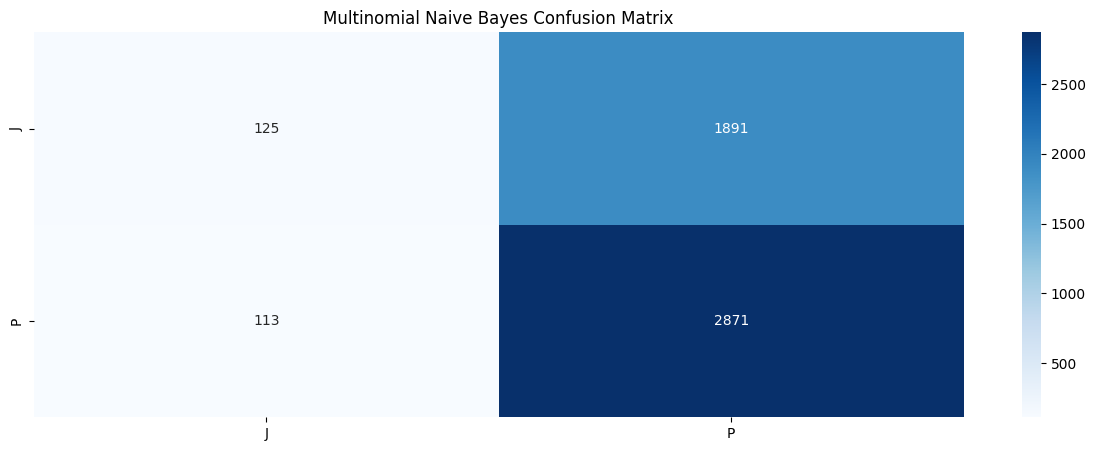

Random Forest Classification Report:
              precision    recall  f1-score   support

           J       0.54      0.21      0.30      2016
           P       0.62      0.88      0.73      2984

    accuracy                           0.61      5000
   macro avg       0.58      0.54      0.52      5000
weighted avg       0.59      0.61      0.56      5000



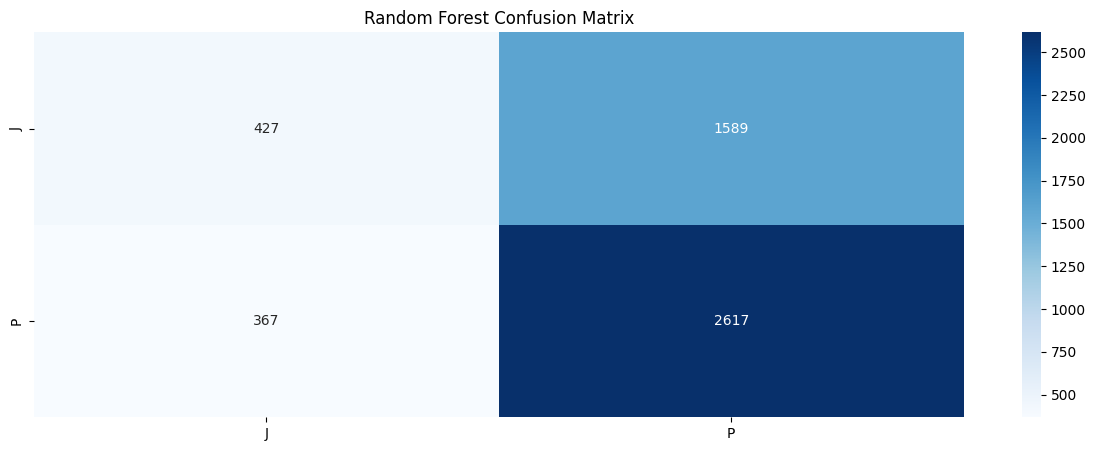

In [28]:
# Repeat the process for each personality trait
personality_traits = ['E/I', 'S/N', 'T/F', 'J/P']

for trait in personality_traits:
    print(f"\nClassification for {trait}:\n")
    
    for clf_name, clf in classifiers.items():
        # Train model for the specific personality trait
        clf.fit(X_train_tfidf, train_data[trait])

        # Predictions for the specific personality trait
        trait_pred = clf.predict(X_test_tfidf)

        # Print classification report for the specific personality trait
        print(f"{clf_name} Classification Report:")
        print(classification_report(test_data[trait], trait_pred))

        # Confusion matrix for the specific personality trait
        plt.figure(figsize=(15, 5))
        sns.heatmap(confusion_matrix(test_data[trait], trait_pred), annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
        plt.title(f'{clf_name} Confusion Matrix')
        plt.show()